In [ ]:
# install folktables for data
pip install folktables

Data Exploration, what does the data look like?

In [ ]:
from folktables import ACSDataSource, ACSIncome
from sklearn.linear_model import LogisticRegression

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)

ca_features, ca_labels, _ = ACSIncome.df_to_numpy(ca_data)
print(ca_data)
features, labels, _ = ACSIncome.df_to_pandas(ca_data)

# Print the shapes of the arrays
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(features[:10])
print(labels[:10])

def map_race(race_value):
    return 0 if race_value == 1.0 else 1 # binarize race (0 = white, 1 = non-white)
def map_sex(sex_value):
    return 1 if sex_value == 1 else 0
features['RAC1P'] = features['RAC1P'].apply(map_race)
features['SEX'] = features['SEX'].apply(map_sex)
print(features[:10])

       RT       SERIALNO  DIVISION  SPORDER  PUMA  REGION  ST   ADJINC  PWGTP  \
0       P  2018GQ0000004         9        1  3701       4   6  1013097     32   
1       P  2018GQ0000013         9        1  7306       4   6  1013097     45   
2       P  2018GQ0000016         9        1  3755       4   6  1013097    109   
3       P  2018GQ0000020         9        1  7319       4   6  1013097     34   
4       P  2018GQ0000027         9        1  6511       4   6  1013097     46   
...    ..            ...       ...      ...   ...     ...  ..      ...    ...   
378812  P  2018HU1400891         9        2  1308       4   6  1013097     94   
378813  P  2018HU1400893         9        1  7108       4   6  1013097    172   
378814  P  2018HU1400893         9        2  7108       4   6  1013097    156   
378815  P  2018HU1400893         9        3  7108       4   6  1013097    172   
378816  P  2018HU1400893         9        4  7108       4   6  1013097    127   

        AGEP  ...  PWGTP71 

Distribution of White vs Non-White:
RAC1P
0    121006
1     74659
Name: count, dtype: int64


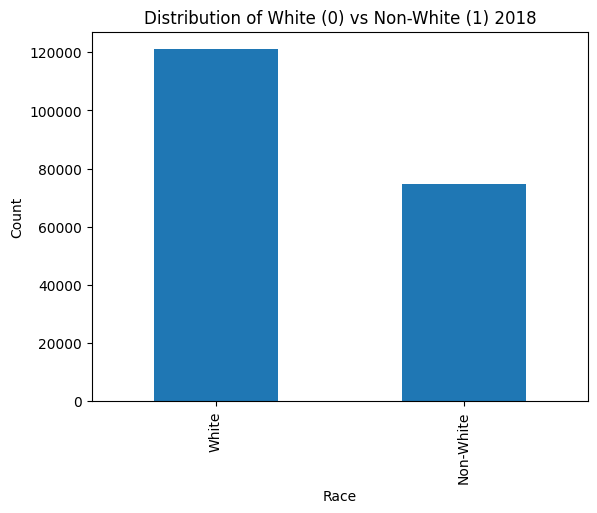

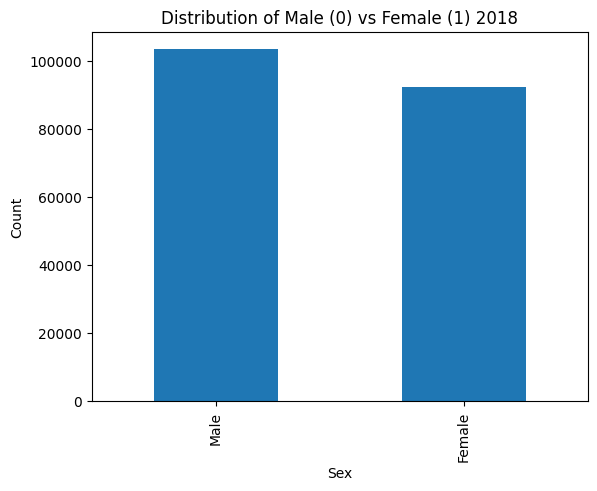

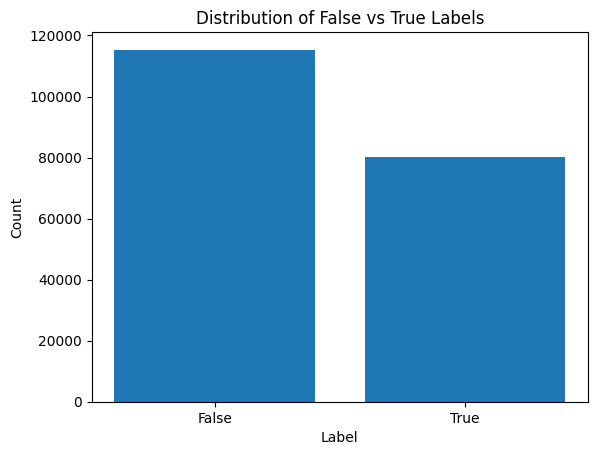

In [ ]:
import matplotlib.pyplot as plt
race_distribution = features['RAC1P'].value_counts()
sex_distribution = features['SEX'].value_counts()
# Print the distribution
print("Distribution of White vs Non-White:")
print(race_distribution)


# Plot the distribution
race_distribution.plot(kind='bar')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of White (0) vs Non-White (1) 2018' )
plt.xticks(ticks=[0, 1], labels=['White', 'Non-White'])
plt.show()

# Plot the distribution
sex_distribution.plot(kind='bar')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.title('Distribution of Male (0) vs Female (1) 2018' )
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

true_count = np.sum(labels)
false_count = len(labels) - true_count

# Create a bar plot
plt.bar(['False', 'True'], [false_count, true_count])

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of False vs True Labels')

# Show plot
plt.show()

2014
2015
2016
2017
2018
   year state  accuracy  precision    recall  f1_score  sex_parity  sex_tpr_0  \
0  2014    CA  0.799967   0.740541  0.672482  0.704873   -0.141419   0.584714   
1  2015    CA  0.792399   0.732564  0.677887  0.704165   -0.141124   0.597509   
2  2016    CA  0.789737   0.739195  0.689987  0.713744   -0.134399   0.622351   
3  2017    CA  0.786918   0.739717  0.705335  0.722117   -0.129028   0.647078   
4  2018    CA  0.754018   0.713019  0.673906  0.692911   -0.173140   0.572966   

   sex_tpr_1  sex_fpr_0  sex_fpr_1  race_parity  race_tpr_0  race_tpr_1  \
0   0.729185   0.103608   0.156866     0.130208    0.713652    0.580613   
1   0.730059   0.113978   0.171098     0.184060    0.738914    0.541143   
2   0.734157   0.120815   0.178381     0.142568    0.725715    0.611663   
3   0.743626   0.135326   0.186836     0.175805    0.762814    0.590079   
4   0.742197   0.148043   0.235129     0.164548    0.730970    0.560519   

   race_fpr_0  race_fpr_1  
0    0.15

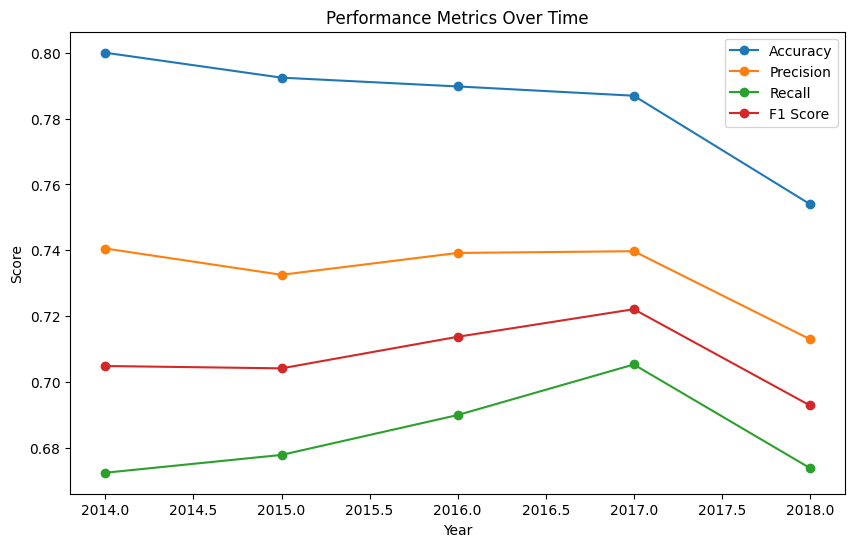

In [ ]:
from folktables import ACSDataSource, ACSIncome
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_fairness_metrics(predictions, labels, sensitive_feature):
    # Statistical Parity
    parity = predictions[sensitive_feature == 0].mean() - predictions[sensitive_feature == 1].mean()

    # True Positive Rate (TPR)
    tpr_0 = (predictions[sensitive_feature == 0] & labels[sensitive_feature == 0]).mean() / labels[sensitive_feature == 0].mean()
    tpr_1 = (predictions[sensitive_feature == 1] & labels[sensitive_feature == 1]).mean() / labels[sensitive_feature == 1].mean()

    # False Positive Rate (FPR)
    fpr_0 = (predictions[sensitive_feature == 0] & ~labels[sensitive_feature == 0]).mean() / (~labels[sensitive_feature == 0]).mean()
    fpr_1 = (predictions[sensitive_feature == 1] & ~labels[sensitive_feature == 1]).mean() / (~labels[sensitive_feature == 1]).mean()

    return parity, tpr_0, tpr_1, fpr_0, fpr_1

years = range(2014, 2019)  # From 2014 to 2018
state = "CA"
results = []

for year in years:
        print(year)
        data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
        data = data_source.get_data(states=[state], download=True)
        features, labels, _ = ACSIncome.df_to_pandas(data)

        # Apply race and sex binarization
        features['RAC1P'] = features['RAC1P'].apply(map_race)
        features['SEX'] = features['SEX'].apply(map_sex)
        labels = labels.values.ravel()  # Ensuring it's a 1D array


        # Split the data into training and testing sets
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

        # Create and train the logistic regression model
        model = LogisticRegression(max_iter=10000)
        model.fit(train_features, train_labels)

        # Evaluate the model on the test data
        test_predictions = model.predict(test_features)
        accuracy = accuracy_score(test_labels, test_predictions)
        precision = precision_score(test_labels, test_predictions)
        recall = recall_score(test_labels, test_predictions)
        f1 = f1_score(test_labels, test_predictions)

        # Calculate fairness metrics
        sex_parity, sex_tpr_0, sex_tpr_1, sex_fpr_0, sex_fpr_1 = calculate_fairness_metrics(test_predictions, test_labels, test_features['SEX'])
        race_parity, race_tpr_0, race_tpr_1, race_fpr_0, race_fpr_1 = calculate_fairness_metrics(test_predictions, test_labels, test_features['RAC1P'])

        # Store the results
        results.append({
            'year': year,
            'state': state,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'sex_parity': sex_parity,
            'sex_tpr_0': sex_tpr_0,
            'sex_tpr_1': sex_tpr_1,
            'sex_fpr_0': sex_fpr_0,
            'sex_fpr_1': sex_fpr_1,
            'race_parity': race_parity,
            'race_tpr_0': race_tpr_0,
            'race_tpr_1': race_tpr_1,
            'race_fpr_0': race_fpr_0,
            'race_fpr_1': race_fpr_1
        })

results_df = pd.DataFrame(results)

# Display the results
print(results_df)


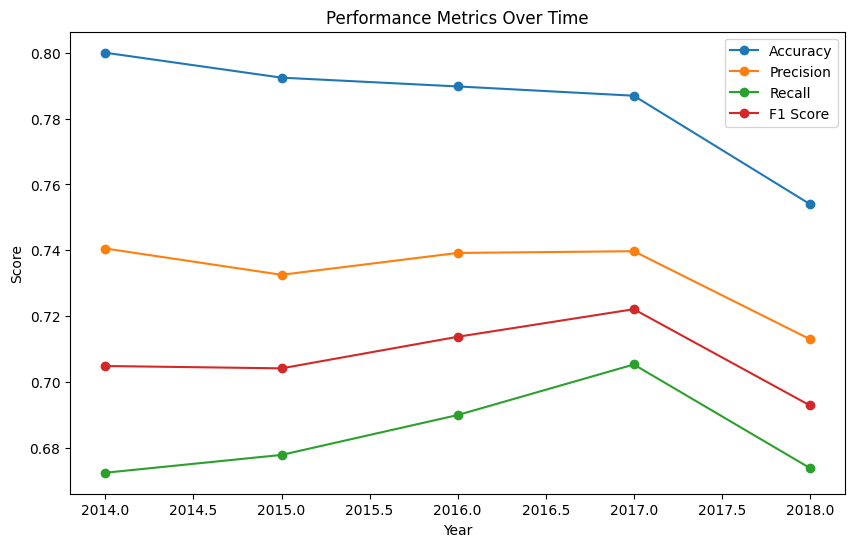

In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))

# Plot accuracy over time
ax.plot(results_df['year'], results_df['accuracy'], marker='o', label='Accuracy')
# Plot precision over time
ax.plot(results_df['year'], results_df['precision'], marker='o', label='Precision')
# Plot recall over time
ax.plot(results_df['year'], results_df['recall'], marker='o', label='Recall')
# Plot F1 score over time
ax.plot(results_df['year'], results_df['f1_score'], marker='o', label='F1 Score')

ax.set_xlabel('Year')
ax.set_ylabel('Score')
ax.set_title('Performance Metrics Over Time')
ax.legend()
plt.show()